In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [17]:
#loading the dataset
df = pd.read_csv(r"C:\Users\David gathara marigi\Downloads\loan_data.csv")

In [18]:
# --- Preprocessing ---
# Convert dates and calculate age
df['DATE_OF_BIRTH'] = pd.to_datetime(df['DATE_OF_BIRTH'], format='%d-%m-%Y')
df['DISBURSAL_DATE'] = pd.to_datetime(df['DISBURSAL_DATE'], format='%d-%m-%Y')
df['AGE_AT_DISBURSAL'] = (df['DISBURSAL_DATE'] - df['DATE_OF_BIRTH']).dt.days / 365.25

# Handle missing employment type
df['EMPLOYMENT_TYPE'] = df['EMPLOYMENT_TYPE'].replace('', 'Unknown')

# Create bureau history feature
df['HAS_BUREAU_HISTORY'] = (df['PERFORM_CNS_SCORE'] > 0).astype(int)

# Convert account age and credit history to months
def parse_years_months(val):
    if pd.isna(val):
        return 0
    parts = val.split()
    years = int(parts[0].replace('yrs', ''))
    months = int(parts[1].replace('mon', ''))
    return years * 12 + months

df['AVERAGE_ACCT_AGE_MONTHS'] = df['AVERAGE_ACCT_AGE'].apply(parse_years_months)
df['CREDIT_HISTORY_LENGTH_MONTHS'] = df['CREDIT_HISTORY_LENGTH'].apply(parse_years_months)

In [19]:
# Impute missing numerical values
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [20]:
# One-hot encode employment type
employment_dummies = pd.get_dummies(df['EMPLOYMENT_TYPE'], prefix='EMPLOYMENT')
df = pd.concat([df, employment_dummies], axis=1)

In [21]:
df.columns

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE_OF_BIRTH',
       'EMPLOYMENT_TYPE', 'DISBURSAL_DATE', 'STATE_ID', 'EMPLOYEE_CODE_ID',
       'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG',
       'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE',
       'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
       'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
       'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT', 'AGE_AT_DISBURSAL', 'HAS_BUREAU_HISTORY',
       'AVERAGE_ACCT_AGE_MONTHS', 'CREDIT_HISTORY_LEN

In [22]:
# --- Feature Selection ---
features = [
    'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'AGE_AT_DISBURSAL',
    'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG',
    'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE', 'HAS_BUREAU_HISTORY',
    'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
    'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT',
    'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS',
    'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT',
    'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
    'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE_MONTHS',
    'CREDIT_HISTORY_LENGTH_MONTHS', 'NO_OF_INQUIRIES',
    'EMPLOYMENT_Salaried', 'EMPLOYMENT_Self employed']

X = df[features]
y = df['LOAN_DEFAULT']

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# --- Handle Imbalance ---
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
weight_ratio = class_weights[1] / class_weights[0]

In [25]:
# --- Gradient Boosting with Hyperparameter Tuning ---
xgb = XGBClassifier(scale_pos_weight=weight_ratio, random_state=42)

In [26]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb = grid_search.best_estimator_

In [27]:
# Make predictions
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

In [28]:
# --- Evaluation ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.7803311929705982

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.74      0.82     17922
         1.0       0.62      0.87      0.72      8709

    accuracy                           0.78     26631
   macro avg       0.77      0.80      0.77     26631
weighted avg       0.82      0.78      0.79     26631

ROC-AUC: 0.8702612764933113


In [29]:
# Feature Importance
importances = best_xgb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print("\nTop 10 Feature Importances:\n", feature_importance_df.sort_values('Importance', ascending=False).head(10))


Top 10 Feature Importances:
                          Feature  Importance
10             PERFORM_CNS_SCORE    0.286853
32      EMPLOYMENT_Self employed    0.226547
31           EMPLOYMENT_Salaried    0.187041
29  CREDIT_HISTORY_LENGTH_MONTHS    0.070181
2                            LTV    0.067115
14             PRI_OVERDUE_ACCTS    0.040768
0               DISBURSED_AMOUNT    0.029912
11            HAS_BUREAU_HISTORY    0.021653
28       AVERAGE_ACCT_AGE_MONTHS    0.008212
16         PRI_SANCTIONED_AMOUNT    0.007806


In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[13224  4698]
 [ 1152  7557]]


In [31]:
# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("AUC Score:", roc_auc)

AUC Score: 0.8702612764933113


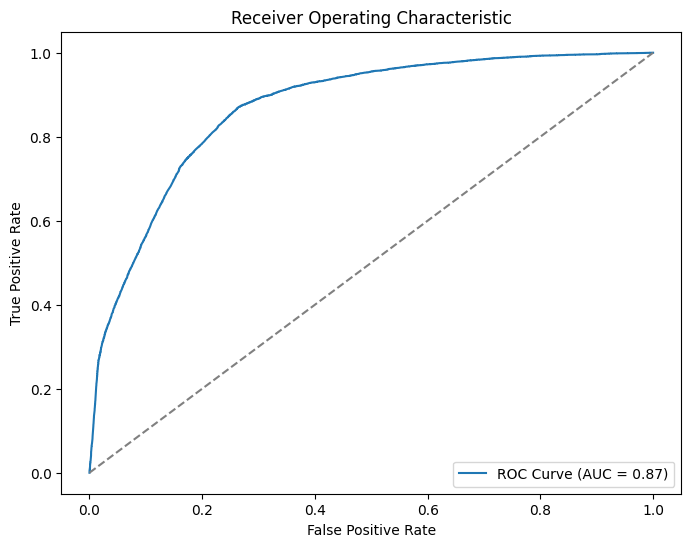

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()